# Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

#### New notebook

This notebook was forked from [this](https://github.com/cdthompson/deepracer-k1999-race-lines/blob/master/Race-Line-Calculation.ipynb) notebook by cdthompson.

This repo only contains the new notebook, not the entire directory. So make sure to download the entire directory from cdthompson's repo.

In [1]:
import glob
import numpy as np
# import cupy as cp
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

In [2]:
# Hyperparams to be adjusted based on track

# Update the track width based on percentage
PERC_WIDTH = 0.8

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS = 4 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS = 2000 # default 1000


## Load the track to analyze

In [3]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['reinvent_base', 'thunder_hill_pro']

Is loop/ring?  True


/tmp/ipykernel_46000/1980746534.py:14: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
/home/siva/.local/lib/python3.11/site-packages/numpy/core/shape_base.py:286: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arrs = atleast_2d(*tup)


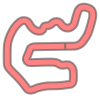

In [4]:
# Replace the name here with the track to analyze
TRACK_NAME = 'reinvent_base'

# Load the center, inner, outer waypoints
waypoints = np.load("tracks/thunder_hill_pro.npy")

# Convert to Shapely objects
center_line = np.array(waypoints[:,0:2])
inner_border = np.array(waypoints[:,2:4])
outer_border = np.array(waypoints[:,4:6])
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

Is loop/ring?  True


/tmp/ipykernel_46000/2964238488.py:33: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))


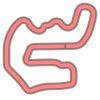

In [5]:
# Own code: Reduce width of track

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
# inner_border_new = waypoints_new[:,2:4]
# outer_border_new = waypoints_new[:,4:6]
# Convert to numpy array
inner_border_new = np.array(waypoints_new[:, 2:4])
outer_border_new = np.array(waypoints_new[:, 4:6])
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

# Display the original track waypoints

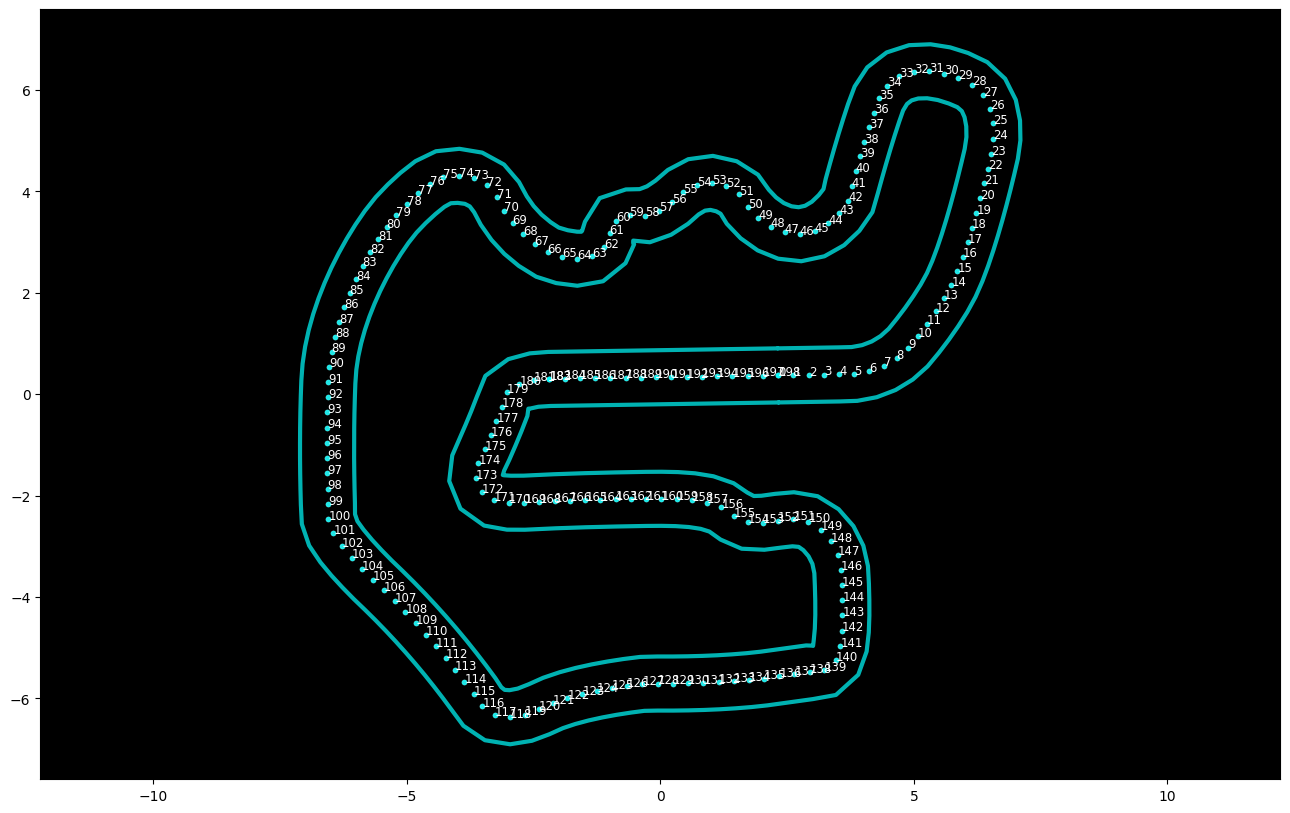

In [6]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)    
    for index, (i_x, i_y) in enumerate(zip(x, y)):
        ax.text(i_x, i_y, f'{index}', color="white", size='small')                            
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob, color='cyan', pt="-"):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, pt, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                            
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints, track=None):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line, pt=".")                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    # plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    # plot_coords(ax, line)                                                       
    plot_line(ax, line)   
    
    if track is None:
        return None
    
    for t in track:
        line = LineString(t)                                                
        plot_coords(ax, line)                                                       
        plot_line(ax, line, color="red", pt=".")    
        
    return None

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
# print_border(ax, center_line, inner_border, outer_border, track=[outer_border_new, inner_border_new])
print_border(ax, center_line, inner_border, outer_border)



In [7]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    # get the distance beween 21, and 23
    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    # get the angle between two distance
    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    # distance of the side
    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [8]:
# Updated iteration parameters
import copy


XI_ITERATIONS = 4  # Increased for more precise adjustment
LINE_ITERATIONS = 2000  # Increased for thorough refinement

# Modified improve_race_line function to refine race line points within track boundaries
def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        
        # take the average of two adjacent curvatures
        target_ci = (c1 + c2) / 2

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0, XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        new_line[i] = new_xi
    return new_line



## Calculate the race line!

In [9]:
print(len(center_line))

199


In [10]:
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
race_line

array([[ 2.3242389 ,  0.36993075],
       [ 2.62518203,  0.37461759],
       [ 2.9261235 ,  0.37947129],
       [ 3.22706795,  0.3840154 ],
       [ 3.52800357,  0.38952576],
       [ 3.82873094,  0.39860421],
       [ 4.12421   ,  0.45362801],
       [ 4.40489936,  0.56114252],
       [ 4.66159344,  0.71749702],
       [ 4.88608456,  0.91734409],
       [ 5.07722354,  1.14971963],
       [ 5.25932169,  1.38934302],
       [ 5.43183112,  1.63594902],
       [ 5.59346151,  1.88979757],
       [ 5.7378149 ,  2.15380853],
       [ 5.85853243,  2.42945004],
       [ 5.96395254,  2.7113421 ],
       [ 6.05966711,  2.99668646],
       [ 6.1486845 ,  3.2841965 ],
       [ 6.23232388,  3.57331705],
       [ 6.3112855 ,  3.86375165],
       [ 6.38674998,  4.15511584],
       [ 6.45866251,  4.44737649],
       [ 6.52723622,  4.74043798],
       [ 6.56940532,  5.03794456],
       [ 6.56394053,  5.338588  ],
       [ 6.50526094,  5.633214  ],
       [ 6.37311387,  5.90226007],
       [ 6.15306401,

In [11]:
# start along centerline of track
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border_new, outer_border_new)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r", flush=True)

/tmp/ipykernel_46000/650139864.py:35: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
/tmp/ipykernel_46000/650139864.py:35: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))


In [ ]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(40, 25))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

# Also print new border
# print_border(ax, loop_race_line, inner_border_new, outer_border_new)

# # Validate race line length
# print("Original centerline length: %0.2f" % l_center_line.length)
# print("New race line length: %0.2f" % LineString(loop_race_line).length)

## Save the raceline as:

1. Binary numpy array for loading from a file
2. Text numpy array for pasting directly into a reward function

In [ ]:
from datetime import datetime

now = datetime.now()
prefix = 'artifacts/raceline_thunder_hill_pro'
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

# Load and visualize a stored track file

In [ ]:
from numpy import array

fname = 'artifacts/raceline_thunder_hill_pro.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
# deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border, track=[deserialized])

In [ ]:
# observe which side the car is expected to run at
center_track = [37,38,48,49,61,71,72,73,74,75,76,77,78,79,80,
                81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,
                96,97,98,99,100,101,102,103,104,105,106,107,
                108,109,110,111,112,113,114,115,116,117,118,
                119,120,121,122,123,124,125,126,127,128,129,
                130,131,132,133,134,135,136,137,154,155,156,
                157,158,159,160,161,162,163,164,165,166,167,
                168,169,170,181,182,183,184,185,186,187,188,
                189,190,191,192,193,194,195,196,197,198]
right_track = [39.40,41,42,43,44,45,46,47,62,63,64,65,66,67,
               68,69,70,171,172,173,174,175,176,177,178,179,180,]

left_track = [i for i in range(0, 198) if i not in right_track + center_track]

# obvious sides
strong_left = [
            6,7,8,9,25,26,27,28,29,30,31,32,33,34,71,72,73,74,75,76139,140,141,142,143,177,178,179,180
        ]
strong_right = [42,43,44,45,46,47,48,49,100,101,102,115,116,117,118,119,120,171,172,173,174]

In [ ]:
print(','.join(map(str, left_track)))

In [ ]:
import numpy as np

# Sample data assuming the first dimension represents distance and the second represents steering angle (replace with your actual data)
# data = np.array([
#     [0, 0],  # Starting point (distance 0, steering angle 0)
#     [10, 10],  # Move forward 10 meters with a slight right turn (steering angle 10)
#     [20, -5],  # Move forward 10 meters with a slight left turn (steering angle -5)
#     [30, 0]   # Move forward 10 meters straight (steering angle 0)
# ])
data=np.load("artifacts/raceline_thunder_hill_pro.npy")

# Extract turn information (assuming steering angle values indicate turn direction)
right_turns = []
left_turns = []

for distance, angle in data:
  if angle > 0:
    right_turns.append(distance)
  elif angle < 0:
    left_turns.append(distance)

# Print the extracted turn information
print("Right turns (distances in meters):", right_turns)
print("Left turns (distances in meters):", left_turns)


In [ ]:
def reward_function(params):

    center_variance = params["distance_from_center"] / params["track_width"]
    #racing line
    left_lane = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,
                 18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,
                 33,34,35,36,39,40,50,51,52,53,54,55,56,57,58,
                 59,60,138,139,140,141,142,143,144,145,146,147,
                 148,149,150,151,152,153] #Fill in the waypoints
    
    center_lane = [37,38,48,49,61,71,72,73,74,75,76,77,78,79,
                   80,81,82,83,84,85,86,87,88,89,90,91,92,93,
                   94,95,96,97,98,99,100,101,102,103,104,105,
                   106,107,108,109,110,111,112,113,114,115,116,
                   117,118,119,120,121,122,123,124,125,126,127,
                   128,129,130,131,132,133,134,135,136,137,154,
                   155,156,157,158,159,160,161,162,163,164,165,
                   166,167,168,169,170,181,182,183,184,185,186,
                   187,188,189,190,191,192,193,194,195,196,197,198]#Fill in the waypoints
    
    right_lane = [39.40,41,42,43,44,45,46,47,62,63,64,65,66,67,
               68,69,70,171,172,173,174,175,176,177,178,179,180]#Fill in the waypoints
    
    #Speed
    speed14 = [55, 56, 57, 58, 59, 60]  # Waypoints for 1.4 m/s
    speed15 = [134, 135, 136, 137, 138, 139, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179]  # Waypoints for 1.5 m/s
    speed16 = [61, 62, 63, 140, 173]  # Waypoints for 1.6 m/s
    speed17 = [54, 112, 113, 114, 115, 116, 117, 166]  # Waypoints for 1.7 m/s
    speed18 = [46, 47, 48, 49, 50, 51, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]  # Waypoints for 1.8 m/s
    speed19 = [22, 23, 24, 25, 26, 27, 37, 38, 39, 40, 41, 42, 52, 53, 67, 68, 69, 70, 71, 72, 73, 74, 75]  # Waypoints for 1.9 m/s
    speed20 = [28, 29, 30, 31, 32, 33, 34, 43, 44, 45, 111, 180]  # Waypoints for 2.0 m/s
    speed21 = [118]  # Waypoints for 2.1 m/s
    speed22 = [64, 95, 96, 97, 98, 99, 100, 101, 144, 155, 156]  # Waypoints for 2.2 m/s
    speed23 = [21, 65, 66, 142, 143]  # Waypoints for 2.3 m/s
    speed25 = [35]  # Waypoints for 2.5 m/s
    speed26 = [76, 119, 141]  # Waypoints for 2.6 m/s
    speed27 = [1, 2, 3, 4, 5, 6, 7]  # Waypoints for 2.7 m/s
    speed28 = [8, 20, 181]  # Waypoints for 2.8 m/s
    speed29 = [19, 157]  # Waypoints for 2.9 m/s
    speed30 = [0, 9, 165]  # Waypoints for 3.0 m/s
    speed36 = [122, 123, 124, 125, 126, 127]  # Waypoints for 3.6 m/s
    speed37 = [120, 121]  # Waypoints for 3.7 m/s
    speed38 = [77, 78, 79]  # Waypoints for 3.8 m/s
    speed39 = [10, 11, 12, 13, 14, 18, 102]  # Waypoints for 3.9 m/s
    speed40 = [15, 16, 17, 36, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 103, 104, 105, 106, 107, 108, 109, 110, 128, 129, 130, 131, 132, 133, 158, 159, 160, 161, 162, 163, 164, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]  # Waypoints for 4.0 m/s
    G_35=[10, 11, 12, 13, 14, 15, 16, 17, 18, 36, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 102, 103, 104, 105, 106, 107, 108, 109, 110, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 158, 159, 160, 161, 162, 163, 164, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
    G_3=[0, 9, 165]
    G_25=[1, 2, 3, 4, 5, 6, 7, 8, 19, 20, 35, 76, 119, 141, 157, 181]
    G_2=[21, 28, 29, 30, 31, 32, 33, 34, 43, 44, 45, 64, 65, 66, 95, 96, 97, 98, 99, 100, 101, 111, 142, 143, 144, 155, 156, 180]
    reward = 21

    if params["all_wheels_on_track"]:
        reward += 10
    else:
        reward -= 10

    if params["closest_waypoints"][1] in left_lane and params["is_left_of_center"]:
        reward += 10
    elif params["closest_waypoints"][1] in right_lane and not params["is_left_of_center"]:
        reward += 10
    elif params["closest_waypoints"][1] in center_lane and center_variance < 0.4:
        reward += 10
    else:
        reward -= 10
    if params["closest_waypoints"][1] in speed14:
        if params["speed"] == 1.4:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed15:
        if params["speed"] == 1.5:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed16:
        if params["speed"] == 1.6:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed17:
        if params["speed"] == 1.7:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed18:
        if params["speed"] == 1.8:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed19:
        if params["speed"] == 1.9:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed20:
        if params["speed"] == 2.0:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed21:
        if params["speed"] == 2.1:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed22:
        if params["speed"] == 2.2:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed23:
        if params["speed"] == 2.3:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed25:
        if params["speed"] == 2.5:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed26:
        if params["speed"] == 2.6:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed27:
        if params["speed"] == 2.7:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed28:
        if params["speed"] == 2.8:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed29:
        if params["speed"] == 2.9:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed30:
        if params["speed"] == 3.0:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed36:
        if params["speed"] == 3.6:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed37:
        if params["speed"] == 3.7:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed38:
        if params["speed"] == 3.8:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed39:
        if params["speed"] == 3.9:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in speed40:
        if params["speed"] == 4.0:
            reward += 10
        else:
            reward -= 10
    if params["closest_waypoints"][1] in G_35:
        if params["speed"] >= 3.5:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in G_3:
        if params["speed"] >= 3.0:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in G_25:
        if params["speed"] >= 2.5:
            reward += 10
        else:
            reward -= 10
    elif params["closest_waypoints"][1] in G_2:
        if params["speed"] >= 2.0:
            reward += 10
        else:
            reward -= 10

        
    
    return float(reward)